# BUSINESS PROBLEM AND DATA

## Problem: Estimating how many counting the calls unplanned outage will cause

## DATA

KOD_NO(Outage ID):
İL: City

İLÇE: District

ŞEBEKE_UNSURU: Indicates the network element where the interruption occurred when opening the interrupt log.

ŞEBEKE_UNSURU_KODU:
It is the network element code where the interruption occurred when opening the interrupt register.

KESİNTİNEDENİNEİLİŞKİN_AÇIKLAMA: It is the reason for the interruption selected by the CRM responsible from the list in the interruption record that opens.

KAYNAĞA_GÖRE: Specifies the type of line where the interruption occurred. It is selected from Distribution-MV / Distribution-LV / Transmission options.

SÜREYE_GÖRE: 
Indicates that the downtime is long/short based on the specified constraint.

SEBEBE_GÖRE: It is selected from External / Security / Network Operator options.

BİLDİRİME_GÖRE: Indicates that the interruption record was opened, with or without notification, while creating the interruption record.

BAŞLAMA_TARİHİ_VE_ZAMANI:It is the date/time indicating that the interruption record is opened in the TSKS system and that the interruption has started.

SONA_ERME_TARİHİ_VE_ZAMANI:
Indicates the date/time when the work order opened on behalf of the interruption record was closed by the field team assigned in INFOR EAM.

KESİNTİ_SÜRESİ: Mathematically it is "END_END_DATE_AND_TIME" - "START_DATE_AND_TIME". It is the value in hours that elapses between the opening of the interruption and the closing of the work order opened in INFOR EAM on behalf of the related interruption.

KENTSEL_OG:
The number of medium voltage interruption lines in the central neighborhoods of all provinces and the central neighborhoods of the districts with a population of 50 000 (fifty thousand) and above, according to the population data announced by TUIK for 2020.

Other columns with "KENTSEL, KIRSAL" is similiar to the "KENTSEL_OG"

### Target

cagri_count: Number of calls caused by the outage

In [104]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn import model_selection
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale, FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve, RepeatedKFold
import random
from unidecode import unidecode
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get the Population Data

In [105]:
izmir_ilce = pd.read_html('https://www.nufusu.com/ilceleri/izmir-ilceleri-nufusu')[0]
manisa_ilce = pd.read_html('http://www.manisa.gov.tr/nufus-ve-dagilim')[0].iloc[:-1,:]
izmir_ilce=izmir_ilce[['İlçe','Toplam Nüfus']].rename(columns={'İlçe':'İLÇE','Toplam Nüfus':'ilce_nufus'})
manisa_ilce=manisa_ilce[['İlçe','İlçe Nüfusu']].rename(columns={'İlçe':'İLÇE','İlçe Nüfusu':'ilce_nufus'})
ilce_nufus=pd.concat([izmir_ilce,manisa_ilce])
ilce_nufus['İLÇE']=ilce_nufus['İLÇE'].apply(unidecode).str.lower()


In [106]:
ilce_nufus.head()

,İLÇE,ilce_nufus
0,buca,517.963
1,karabaglar,478.788
2,bornova,452.867
3,karsiyaka,347.023
4,konak,336.545


## Reading of the Datasets

In [107]:
test = pd.read_csv("../input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/test.csv")
train = pd.read_csv("../input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/train.csv")

# Firstly, Let's Look at The Datasets

### Train & Test

In [108]:
train["type"] = 'train'
test["type"] = 'test'


df = {}
df = pd.DataFrame(df)
df = pd.concat([train,test],axis=0).reset_index(drop=True)

In [109]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)
display(df.head(5))
display(df.shape)

,KESİNTİ_NO,İL,İLÇE,ŞEBEKE_UNSURU,ŞEBEKE_UNSURU_KODU,KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA,KAYNAĞA_GÖRE,SÜREYE_GÖRE,SEBEBE_GÖRE,BİLDİRİME_GÖRE,BAŞLAMA_TARİHİ_VE_ZAMANI,SONA_ERME_TARİHİ_VE_ZAMANI,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,KOD_NO,KADEME,OutageID,cagri_count,type
0,2279970,İZMİR,URLA,OG Fideri,TR-129 35-19-L00129_DIREK TIPI TRAFO HUCRESI H01_2034310,OG Sigorta Atması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,11.04.2022 07:06:48,11.04.2022 10:11:11,3.073056,1,146,0,0,0,0,3.073056,448.666111,0.0,0.0,0.0,0.0,0.0,0.0,2279970,0.0,train
1,2228825,İZMİR,BORNOVA,OG Fideri,K-633 35-02-K00633_K-259 K01_2034347,OG Fider Açması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,30.01.2022 20:27:00,31.01.2022 01:32:04,5.084444,3,1613,0,0,0,0,15.253333,8201.208888,0.0,0.0,0.0,0.0,0.0,0.0,2228825,153.0,train
2,2228866,İZMİR,BORNOVA,OG Fideri,K-633 35-02-K00633_K-259 K01_2034347,OG Fider Açması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,31.01.2022 03:47:00,31.01.2022 05:30:45,1.729167,3,1613,0,0,0,0,5.187500,2789.145832,0.0,0.0,0.0,0.0,0.0,0.0,2228866,8.0,train
3,2272136,İZMİR,KARABAĞLAR,TM Fideri,UZUNDERE TM 35-01-A00013_İKİZTEPE M10_2034358,OG Yeraltı Kablo Arızası,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,31.03.2022 16:34:23,31.03.2022 17:21:07,0.778889,6,1556,0,0,0,0,4.673333,1211.951110,0.0,0.0,0.0,0.0,0.0,0.0,2272136,0.0,train
4,2310105,İZMİR,BERGAMA,OG Fideri,SİNDEL TR-1 35-16-M00029_DIREK TIPI TRAFO HUCRESI H01_2034424,OG Sigorta Atması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,03.06.2022 21:11:27,03.06.2022 22:44:57,1.558333,1,101,0,0,0,0,1.558333,157.391667,0.0,0.0,0.0,0.0,0.0,0.0,2310105,0.0,train


(122143, 30)


# MERGING POPULATION DATA AND DF

In [110]:
df['İL']=df['İL'].apply(unidecode).str.lower()
df['İLÇE']=df['İLÇE'].apply(unidecode).str.lower()

In [111]:
df = pd.merge(df,ilce_nufus,on=['İLÇE'],how='left')

# GET SPECIAL DAYS FOR TURKEY AND MERGING WITH DF

In [112]:
df_date = []
for i in range(len(df)):
    df_date.append(df["BAŞLAMA_TARİHİ_VE_ZAMANI"][i].split(" ")[0])
    
df_date_dict = {"DATE": df_date}
df_date_dict = pd.DataFrame(df_date_dict)
df_date_dict.head()
df["DATE"] = df_date_dict

In [113]:
holidays_2022 = pd.read_html("https://www.officeholidays.com/countries/turkey/2022")[0]

In [114]:
holidays_2022.head()

,Day,Date,Holiday Name,Type,Comments
0,Saturday,Jan 01,New Year's Day,National Holiday,NaN
1,Saturday,Apr 23,National Sovereignty and Children's Day,National Holiday,NaN
2,Sunday,May 01,Labour and Solidarity Day,National Holiday,International Workers' Day
3,Monday,May 02,Ramazan Bayramı,National Holiday,End of Ramadan
4,Tuesday,May 03,Ramazan Bayramı Holiday,National Holiday,NaN


In [115]:
days = []
years = []
for i in range(len(holidays_2022)):
    days.append(holidays_2022["Date"][i])
    years.append(str(f"{days[i]},2022"))

    
holidays_2022["holidays"] = years 

In [116]:
holidays_2022.head()

,Day,Date,Holiday Name,Type,Comments,holidays
0,Saturday,Jan 01,New Year's Day,National Holiday,NaN,"Jan 01,2022"
1,Saturday,Apr 23,National Sovereignty and Children's Day,National Holiday,NaN,"Apr 23,2022"
2,Sunday,May 01,Labour and Solidarity Day,National Holiday,International Workers' Day,"May 01,2022"
3,Monday,May 02,Ramazan Bayramı,National Holiday,End of Ramadan,"May 02,2022"
4,Tuesday,May 03,Ramazan Bayramı Holiday,National Holiday,NaN,"May 03,2022"


In [117]:
holidays_2021 = pd.read_html("https://www.officeholidays.com/countries/turkey/2021")[0]

In [118]:
holidays_2021.head()

,Day,Date,Holiday Name,Type,Comments
0,Friday,Jan 01,New Year's Day,National Holiday,NaN
1,Friday,Apr 23,National Sovereignty and Children's Day,National Holiday,NaN
2,Saturday,May 01,Labour and Solidarity Day,National Holiday,International Workers' Day
3,Wednesday,May 12,Ramazan Bayramı Holiday,National Holiday,NaN
4,Thursday,May 13,Ramazan Bayramı,National Holiday,End of Ramadan


In [119]:
days = []
years = []
for i in range(len(holidays_2021)):
    days.append(holidays_2021["Date"][i])
    years.append(str(f"{days[i]},2021"))

    
holidays_2021["holidays"] = years 

In [120]:
holidays_2021.head()

,Day,Date,Holiday Name,Type,Comments,holidays
0,Friday,Jan 01,New Year's Day,National Holiday,NaN,"Jan 01,2021"
1,Friday,Apr 23,National Sovereignty and Children's Day,National Holiday,NaN,"Apr 23,2021"
2,Saturday,May 01,Labour and Solidarity Day,National Holiday,International Workers' Day,"May 01,2021"
3,Wednesday,May 12,Ramazan Bayramı Holiday,National Holiday,NaN,"May 12,2021"
4,Thursday,May 13,Ramazan Bayramı,National Holiday,End of Ramadan,"May 13,2021"


In [121]:
holidays = pd.concat([holidays_2022, holidays_2021], axis=0).reset_index(drop=True)

In [122]:
holidays = holidays[["holidays"]]

In [123]:
from datetime import datetime
date_list = []
for i in range(len(holidays)):
    date_list.append(datetime.strptime(f"{holidays['holidays'][i]}", "%b %d,%Y"))

dates = {"DATE": date_list, "holidays":1}
dates = pd.DataFrame(dates)


In [124]:
dates["DATE"].head()

0   2022-01-01
1   2022-04-23
2   2022-05-01
3   2022-05-02
4   2022-05-03
Name: DATE, dtype: datetime64[ns]

In [125]:
df["DATE"] = pd.to_datetime(df["DATE"])

In [126]:
df["DATE"].head()

0   2022-11-04
1   2022-01-30
2   2022-01-31
3   2022-03-31
4   2022-03-06
Name: DATE, dtype: datetime64[ns]

In [127]:
df = pd.merge(df,dates, on=["DATE"], how = 'left')

In [128]:
df["holidays"].isnull().sum()

116609

In [129]:
df["holidays"].fillna(0,inplace=True)

In [130]:
df.head()

,KESİNTİ_NO,İL,İLÇE,ŞEBEKE_UNSURU,ŞEBEKE_UNSURU_KODU,KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA,KAYNAĞA_GÖRE,SÜREYE_GÖRE,SEBEBE_GÖRE,BİLDİRİME_GÖRE,BAŞLAMA_TARİHİ_VE_ZAMANI,SONA_ERME_TARİHİ_VE_ZAMANI,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,KOD_NO,KADEME,OutageID,cagri_count,type,ilce_nufus,DATE,holidays
0,2279970,izmir,urla,OG Fideri,TR-129 35-19-L00129_DIREK TIPI TRAFO HUCRESI H01_2034310,OG Sigorta Atması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,11.04.2022 07:06:48,11.04.2022 10:11:11,3.073056,1,146,0,0,0,0,3.073056,448.666111,0.0,0.0,0.0,0.0,0.0,0.0,2279970,0.0,train,72.741,2022-11-04,0.0
1,2228825,izmir,bornova,OG Fideri,K-633 35-02-K00633_K-259 K01_2034347,OG Fider Açması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,30.01.2022 20:27:00,31.01.2022 01:32:04,5.084444,3,1613,0,0,0,0,15.253333,8201.208888,0.0,0.0,0.0,0.0,0.0,0.0,2228825,153.0,train,452.867,2022-01-30,0.0
2,2228866,izmir,bornova,OG Fideri,K-633 35-02-K00633_K-259 K01_2034347,OG Fider Açması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,31.01.2022 03:47:00,31.01.2022 05:30:45,1.729167,3,1613,0,0,0,0,5.187500,2789.145832,0.0,0.0,0.0,0.0,0.0,0.0,2228866,8.0,train,452.867,2022-01-31,0.0
3,2272136,izmir,karabaglar,TM Fideri,UZUNDERE TM 35-01-A00013_İKİZTEPE M10_2034358,OG Yeraltı Kablo Arızası,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,31.03.2022 16:34:23,31.03.2022 17:21:07,0.778889,6,1556,0,0,0,0,4.673333,1211.951110,0.0,0.0,0.0,0.0,0.0,0.0,2272136,0.0,train,478.788,2022-03-31,0.0
4,2310105,izmir,bergama,OG Fideri,SİNDEL TR-1 35-16-M00029_DIREK TIPI TRAFO HUCRESI H01_2034424,OG Sigorta Atması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,03.06.2022 21:11:27,03.06.2022 22:44:57,1.558333,1,101,0,0,0,0,1.558333,157.391667,0.0,0.0,0.0,0.0,0.0,0.0,2310105,0.0,train,104.98,2022-03-06,0.0


# EXPLORATORY DATA ANALYSIS

In [131]:
print("*"*30, "HEAD", "*"*30)
display(df.head(5))
print("*"*30, "SHAPE", "*"*30)
print(f"Rows: {df.shape[0]}\nColumns: {df.shape[1]}")
print("*"*30, "INFO", "*"*30)
display(df.info())
print("*"*30, "DESCRIBE", "*"*30)
display(df.describe().T)
print("*"*30, "NULL?", "*"*30)
display(df.isnull().sum())
print("*"*30, "DUPLICATED", "*"*30)
display(df.duplicated().sum())
print("*"*30, "EXPLAINING", "*"*30)

****************************** HEAD ******************************


,KESİNTİ_NO,İL,İLÇE,ŞEBEKE_UNSURU,ŞEBEKE_UNSURU_KODU,KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA,KAYNAĞA_GÖRE,SÜREYE_GÖRE,SEBEBE_GÖRE,BİLDİRİME_GÖRE,BAŞLAMA_TARİHİ_VE_ZAMANI,SONA_ERME_TARİHİ_VE_ZAMANI,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,KOD_NO,KADEME,OutageID,cagri_count,type,ilce_nufus,DATE,holidays
0,2279970,izmir,urla,OG Fideri,TR-129 35-19-L00129_DIREK TIPI TRAFO HUCRESI H01_2034310,OG Sigorta Atması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,11.04.2022 07:06:48,11.04.2022 10:11:11,3.073056,1,146,0,0,0,0,3.073056,448.666111,0.0,0.0,0.0,0.0,0.0,0.0,2279970,0.0,train,72.741,2022-11-04,0.0
1,2228825,izmir,bornova,OG Fideri,K-633 35-02-K00633_K-259 K01_2034347,OG Fider Açması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,30.01.2022 20:27:00,31.01.2022 01:32:04,5.084444,3,1613,0,0,0,0,15.253333,8201.208888,0.0,0.0,0.0,0.0,0.0,0.0,2228825,153.0,train,452.867,2022-01-30,0.0
2,2228866,izmir,bornova,OG Fideri,K-633 35-02-K00633_K-259 K01_2034347,OG Fider Açması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,31.01.2022 03:47:00,31.01.2022 05:30:45,1.729167,3,1613,0,0,0,0,5.187500,2789.145832,0.0,0.0,0.0,0.0,0.0,0.0,2228866,8.0,train,452.867,2022-01-31,0.0
3,2272136,izmir,karabaglar,TM Fideri,UZUNDERE TM 35-01-A00013_İKİZTEPE M10_2034358,OG Yeraltı Kablo Arızası,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,31.03.2022 16:34:23,31.03.2022 17:21:07,0.778889,6,1556,0,0,0,0,4.673333,1211.951110,0.0,0.0,0.0,0.0,0.0,0.0,2272136,0.0,train,478.788,2022-03-31,0.0
4,2310105,izmir,bergama,OG Fideri,SİNDEL TR-1 35-16-M00029_DIREK TIPI TRAFO HUCRESI H01_2034424,OG Sigorta Atması,Dağıtım-OG,Uzun,Şebeke işletmecisi,Bildirimsiz,03.06.2022 21:11:27,03.06.2022 22:44:57,1.558333,1,101,0,0,0,0,1.558333,157.391667,0.0,0.0,0.0,0.0,0.0,0.0,2310105,0.0,train,104.98,2022-03-06,0.0


****************************** SHAPE ******************************
Rows: 122143
Columns: 33
****************************** INFO ******************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 122143 entries, 0 to 122142
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   KESİNTİ_NO                         122143 non-null  int64         
 1   İL                                 122143 non-null  object        
 2   İLÇE                               122143 non-null  object        
 3   ŞEBEKE_UNSURU                      122143 non-null  object        
 4   ŞEBEKE_UNSURU_KODU                 122143 non-null  object        
 5   KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA  122143 non-null  object        
 6   KAYNAĞA_GÖRE                       122143 non-null  object        
 7   SÜREYE_GÖRE                        122143 non-null  object        
 8   SEBE

None

****************************** DESCRIBE ******************************


,count,mean,std,min,25%,50%,75%,max
KESİNTİ_NO,122143.0,2.122119e+06,184403.031374,1.805939e+06,1.905962e+06,2.178353e+06,2.281036e+06,2.366166e+06
KESİNTİ_SÜRESİ,122143.0,2.319656e+00,2.511308,-2.962778e+00,9.144444e-01,1.695278e+00,2.987083e+00,2.893233e+02
KENTSEL_OG,122143.0,8.145895e+00,38.350783,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.984000e+03
KENTSEL_AG,122143.0,3.619160e+02,1713.217461,0.000000e+00,0.000000e+00,4.000000e+00,8.700000e+01,7.096100e+04
KENTALTI_OG,122143.0,1.328738e+00,12.930263,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.500000e+02
KENTALTI_AG,122143.0,6.119802e+01,591.431749,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.478100e+04
KIRSAL_OG,122143.0,2.490302e+00,16.708871,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.820000e+02
KIRSAL_AG,122143.0,6.396454e+01,390.796267,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.168300e+04
TOPLAM_KENTSEL_OG,122143.0,7.798701e+00,58.028296,-7.414444e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.374702e+03
TOPLAM_KENTSEL_AG,122143.0,3.066625e+02,1693.363855,-2.233601e+03,0.000000e+00,7.180000e+00,1.169994e+02,2.160619e+05


****************************** NULL? ******************************


KESİNTİ_NO                               0
İL                                       0
İLÇE                                     0
ŞEBEKE_UNSURU                            0
ŞEBEKE_UNSURU_KODU                       0
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA        0
KAYNAĞA_GÖRE                             0
SÜREYE_GÖRE                              0
SEBEBE_GÖRE                              0
BİLDİRİME_GÖRE                           0
BAŞLAMA_TARİHİ_VE_ZAMANI                 0
SONA_ERME_TARİHİ_VE_ZAMANI               0
KESİNTİ_SÜRESİ                           0
KENTSEL_OG                               0
KENTSEL_AG                               0
KENTALTI_OG                              0
KENTALTI_AG                              0
KIRSAL_OG                                0
KIRSAL_AG                                0
TOPLAM_KENTSEL_OG                        0
TOPLAM_KENTSEL_AG                        0
TOPLAM_KENTALTI_OG                       0
TOPLAM_KENTALTI_AG                       0
TOPLAM_KIRS

****************************** DUPLICATED ******************************


0

****************************** EXPLAINING ******************************


- We have 
    - Rows: 122143
    - Columns: 30
- We have
    - 12 object
    - 11 float
    - 6 int
    - 1 datetime variables.
- Minumum "kesinti süresi" is -2.96 there should be something wrong. I'll fix it.
- Also, in TOPLAM_KENTSEL_AG and TOPLAM_KENTSEL_OG minumum values are minus. I'll fix it too.
- There is no null values. Null values on "cagri_count" and "Kod_No" because of the test dataset.
- There is only one duplicated value. We will get rid off that.
      

### "İL" vs "cagri_count"

<AxesSubplot:xlabel='İL'>

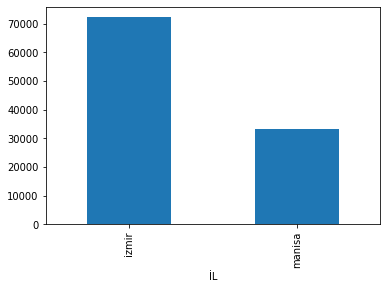

In [132]:
df.groupby("İL")["cagri_count"].count().plot(kind="bar")

#### Maximum cagri_count from İzmir

### "İLÇE" vs "cagri_count"

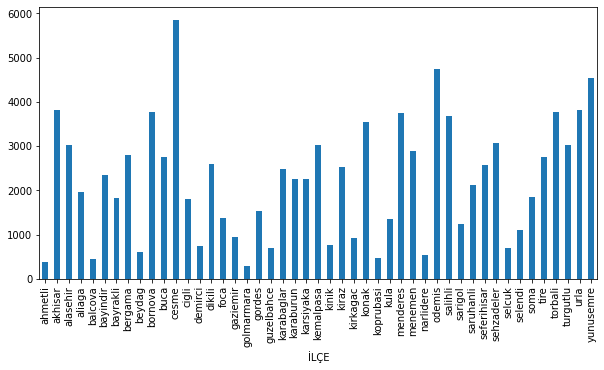

In [133]:
df.groupby("İLÇE")["cagri_count"].count().plot(kind="bar")
fig = plt.gcf()
fig.set_size_inches(10,5)

#### Maximum cagri_count from Cesme

In [134]:
pd.crosstab([df.İLÇE,df.ilce_nufus],df.cagri_count.count())

,col_0,105392
İLÇE,ilce_nufus,
ahmetli,16.807,418
akhisar,176.000,4544
alasehir,105.380,3564
aliaga,103.364,2238
balcova,80.513,511
bayindir,40.049,2790
bayrakli,296.839,2094
bergama,104.98,3187
beydag,12.197,710


#### While population is increasing, "cagri_count" might be decreased. We'll examine it

### "SÜREYE_GÖRE" vs "cagri_count"

<AxesSubplot:xlabel='SÜREYE_GÖRE'>

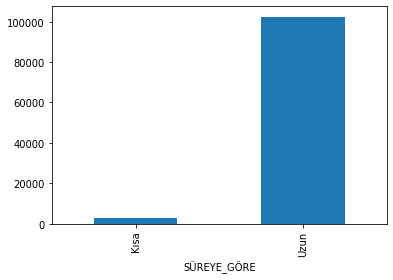

In [135]:
df.groupby("SÜREYE_GÖRE")["cagri_count"].count().plot(kind="bar")

#### Almost all interruptions are "Long"

### SEBEBE_GÖRE vs cagri_count

<AxesSubplot:xlabel='SEBEBE_GÖRE'>

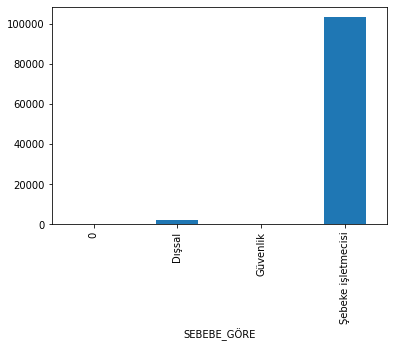

In [136]:
df.groupby("SEBEBE_GÖRE")["cagri_count"].count().plot(kind="bar")

In [137]:
df.groupby("SEBEBE_GÖRE")["cagri_count"].count()

SEBEBE_GÖRE
0                          1
Dışsal                  2065
Güvenlik                 107
Şebeke işletmecisi    103219
Name: cagri_count, dtype: int64

#### The most electric interruption's reason is caused by the electricity grid operator. External reason's count is very low. Because of this, I didn't add the weather data

### KAYNAĞA_GÖRE vs cagri_count

<AxesSubplot:xlabel='KAYNAĞA_GÖRE'>

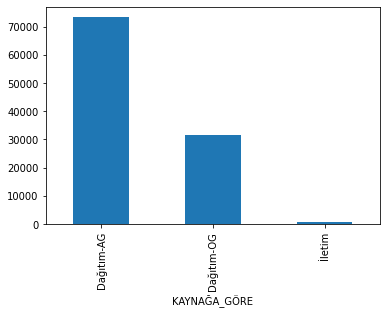

In [138]:
df.groupby("KAYNAĞA_GÖRE")["cagri_count"].count().plot(kind="bar")

#### There are three type of the interruption power lines. And interruption rate in order is: Dağıtım-AG>Dağıtım-OG>iletim

### KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA vs cagri_count

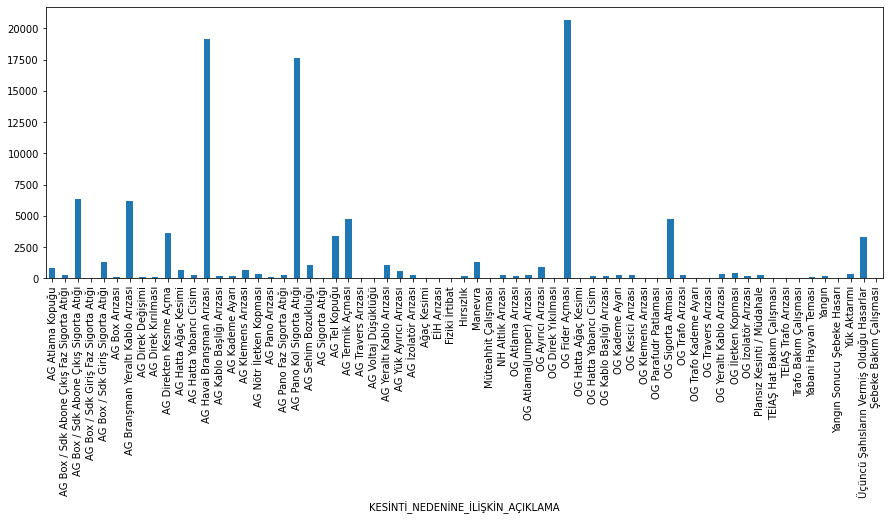

In [139]:
df.groupby("KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA")["cagri_count"].count().plot(kind="bar")
fig = plt.gcf()
fig.set_size_inches(15,5)

In [140]:
df["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"].nunique()

65

#### There are 65 type of reason of interruption. We'll use this feature to do one-hot encoding

## ŞEBEKE_UNSURU vs cagri_count

<AxesSubplot:xlabel='ŞEBEKE_UNSURU'>

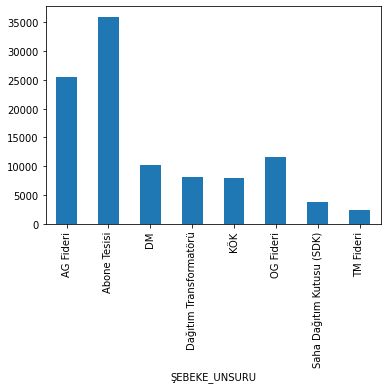

In [141]:
df.groupby("ŞEBEKE_UNSURU")["cagri_count"].count().plot(kind="bar")

### BİLDİRİME_GÖRE vs cagri_count

In [142]:
display(df["BİLDİRİME_GÖRE"].unique())
pd.crosstab(df.BİLDİRİME_GÖRE, df.cagri_count.count())

array(['Bildirimsiz'], dtype=object)

col_0,105392
BİLDİRİME_GÖRE,
Bildirimsiz,122143


#### There are only one type of the feature. So, it's redundant because we haven't any other information to compare the cagri_count. **I'll drop this feature.**

### KESİNTİ_SÜRESİ vs cagri_count

In [143]:
df[["KESİNTİ_SÜRESİ"]].describe().T

,count,mean,std,min,25%,50%,75%,max
KESİNTİ_SÜRESİ,122143.0,2.319656,2.511308,-2.962778,0.914444,1.695278,2.987083,289.323333


####  - Mean Interruption time is 2.32 hours. Max is almost 300 hours. It is so much. Let's look at the outliers 
#### - Min value of "KESİNTİ_SÜRESİ" is -2.96 and it can't be happened. So I'll delete below the 0 values.

In [144]:
df_kesinti = df.query('KESİNTİ_SÜRESİ < 0')

In [145]:
df_kesinti

,KESİNTİ_NO,İL,İLÇE,ŞEBEKE_UNSURU,ŞEBEKE_UNSURU_KODU,KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA,KAYNAĞA_GÖRE,SÜREYE_GÖRE,SEBEBE_GÖRE,BİLDİRİME_GÖRE,BAŞLAMA_TARİHİ_VE_ZAMANI,SONA_ERME_TARİHİ_VE_ZAMANI,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,KOD_NO,KADEME,OutageID,cagri_count,type,ilce_nufus,DATE,holidays
8707,2310569,manisa,salihli,DM,SALİHLİ İM 45-78-A00001_ŞEHİR-4 L011_48928852,Müteahhit Çalışması,Dağıtım-OG,Kısa,Şebeke işletmecisi,Bildirimsiz,04.06.2022 18:10:28,04.06.2022 15:12:42,-2.962778,0,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2310569,0.0,train,164.710,2022-04-06,0.0
17682,2308730,manisa,saruhanli,OG Fideri,SARUHANLI TR-15 45-80-M00015_SARUHANLI TR-13 M02_60962831,Trafo Bakım Çalışması,Dağıtım-OG,Kısa,Şebeke işletmecisi,Bildirimsiz,02.06.2022 12:07:16,02.06.2022 10:16:03,-1.853611,4,1205,0,0,0,0,-7.414444,-2233.601389,0.0,0.0,0.0,0.0,0.0,0.0,2308730,0.0,train,56.166,2022-02-06,0.0


In [146]:
df_kesinti.index

Int64Index([8707, 17682], dtype='int64')

In [147]:
for i in df_kesinti.index:
    df = df.drop(i, axis=0)

In [148]:
df.shape

(122141, 33)

#### I deleted the wrong observations. Also, it is deleted TOPLAM_KENTSEL_OG-AG wrong values.
#### Let's look at the outliers.

<AxesSubplot:>

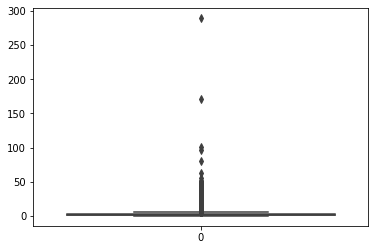

In [149]:
sns.boxplot(data=df["KESİNTİ_SÜRESİ"])

#### We have a large dataset, so there are much outliers. I'll handle with outliers.

####  Much variables are in around 0-100 hours.

<AxesSubplot:xlabel='KESİNTİ_SÜRESİ', ylabel='Count'>

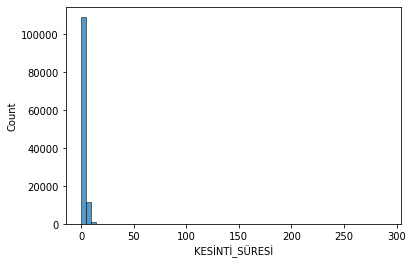

In [150]:
sns.histplot(data=df, x="KESİNTİ_SÜRESİ", bins=60)

#### It can be clearly seen from the histplot, almost all variables are stay in 0-15 hours.

<AxesSubplot:xlabel='KESİNTİ_SÜRESİ', ylabel='cagri_count'>

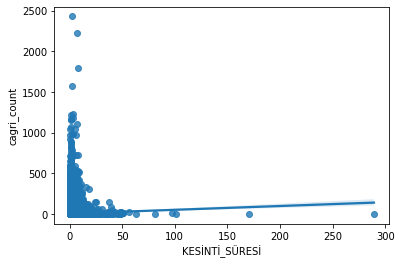

In [151]:
sns.regplot(data=df, x="KESİNTİ_SÜRESİ", y="cagri_count")

In [152]:
df["KESİNTİ_SÜRESİ"].corr(df["cagri_count"])

0.03806309816142066

#### Correlation number is so low, because density of the "KESİNTİ_SÜRESİ" so high in 0-15 hours. This feature should be an important in modelling, because while interruption time is increasing, calling counts should be increasing also.

#### **Handling with outliers in "KESİNTİ_SÜRESİ"** 

In [153]:
df_kesinti= df[["KESİNTİ_SÜRESİ"]]
Q1 = df_kesinti.quantile(0.99)
Q1

KESİNTİ_SÜRESİ    9.789056
Name: 0.99, dtype: float64

#### Our upper quantile is so low, If we delete the all high value above from the quantile, we can get low model performance. So, I decided to delete above the 55 hours of values. It may not effect too much but, If it's a little bit valuable, It is good for us.

In [154]:
upper_threshold = 55
kesinti_süresi_outliers = df.query("KESİNTİ_SÜRESİ > 55")
kesinti_süresi_outliers["KESİNTİ_SÜRESİ"] = upper_threshold

In [155]:
kesinti_süresi_nonoutliers = df.query("KESİNTİ_SÜRESİ <= 55")

In [156]:
df = pd.concat([kesinti_süresi_nonoutliers,kesinti_süresi_outliers], axis=0).reset_index(drop=True)

<AxesSubplot:xlabel='KESİNTİ_SÜRESİ', ylabel='cagri_count'>

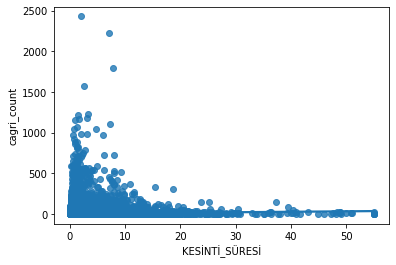

In [157]:
sns.regplot(data=df, x="KESİNTİ_SÜRESİ", y="cagri_count")

In [158]:
df["KESİNTİ_SÜRESİ"].corr(df["cagri_count"])

0.04212993444900774

#### We get improved our correlation, but in least way (0.01).

### BAŞLAMA_TARİHİ_VE_ZAMANI and SONA_ERME_TARİHİ_VE_ZAMANI

In [159]:
df["SONA_ERME_TARİHİ_VE_ZAMANI"] = pd.to_datetime(df["SONA_ERME_TARİHİ_VE_ZAMANI"])
df["BAŞLAMA_TARİHİ_VE_ZAMANI"] = pd.to_datetime(df["BAŞLAMA_TARİHİ_VE_ZAMANI"])

In [160]:
df['BAŞLAMA_TARİHİ_VE_ZAMANI_year'] = df['BAŞLAMA_TARİHİ_VE_ZAMANI'].dt.year
df['BAŞLAMA_TARİHİ_VE_ZAMANI_month'] = df['BAŞLAMA_TARİHİ_VE_ZAMANI'].dt.month
df['BAŞLAMA_TARİHİ_VE_ZAMANI_hour'] = df['BAŞLAMA_TARİHİ_VE_ZAMANI'].dt.hour


df['SONA_ERME_TARİHİ_VE_ZAMANI_year'] = df['SONA_ERME_TARİHİ_VE_ZAMANI'].dt.year
df['SONA_ERME_TARİHİ_VE_ZAMANI_month'] = df['SONA_ERME_TARİHİ_VE_ZAMANI'].dt.month
df['SONA_ERME_TARİHİ_VE_ZAMANI_hour'] = df['SONA_ERME_TARİHİ_VE_ZAMANI'].dt.hour

<AxesSubplot:xlabel='BAŞLAMA_TARİHİ_VE_ZAMANI', ylabel='cagri_count'>

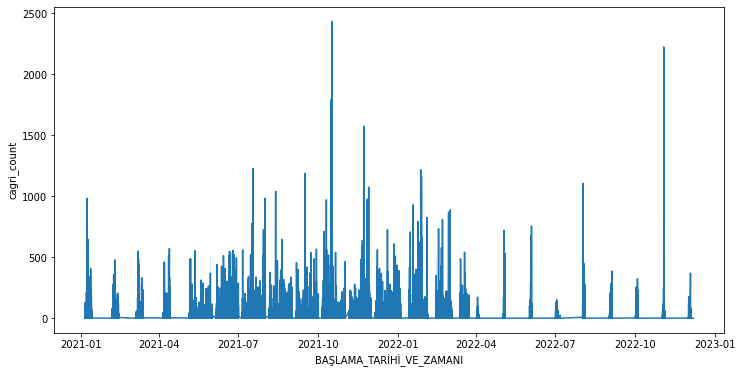

In [161]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df, x="BAŞLAMA_TARİHİ_VE_ZAMANI", y="cagri_count", ax=ax)

<AxesSubplot:xlabel='SONA_ERME_TARİHİ_VE_ZAMANI', ylabel='cagri_count'>

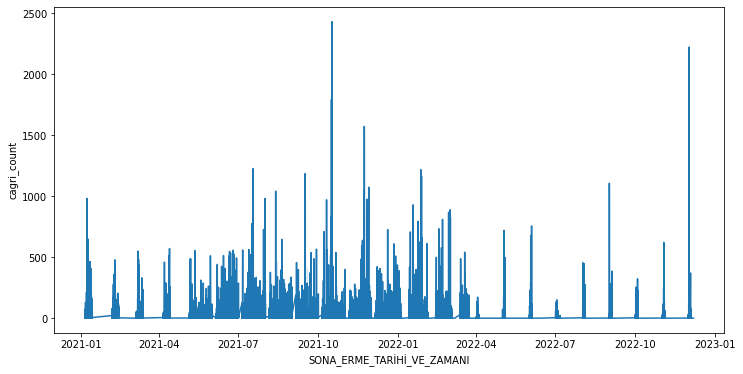

In [162]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df, x="SONA_ERME_TARİHİ_VE_ZAMANI", y="cagri_count", ax=ax)

In [163]:
df_train = df.query("type=='train'")

<AxesSubplot:xlabel='BAŞLAMA_TARİHİ_VE_ZAMANI'>

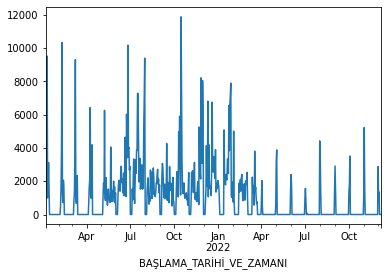

In [164]:
df_train.set_index("BAŞLAMA_TARİHİ_VE_ZAMANI").resample("D")["cagri_count"].sum().plot()

#### It seems, the most cagri_count in Summer and Fall
#### **Let's dive deep into and do some feature engineering and explore**

<AxesSubplot:xlabel='BAŞLAMA_TARİHİ_VE_ZAMANI_year'>

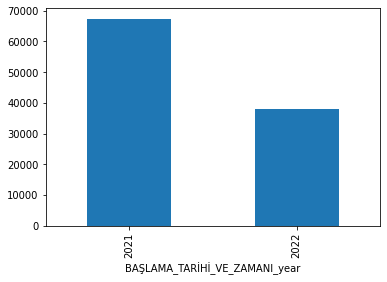

In [165]:
df.groupby('BAŞLAMA_TARİHİ_VE_ZAMANI_year')["cagri_count"].count().plot(kind="bar")

#### Calling counts are much more in 2021 maybe because of the pandemic situations.

<AxesSubplot:xlabel='BAŞLAMA_TARİHİ_VE_ZAMANI_month'>

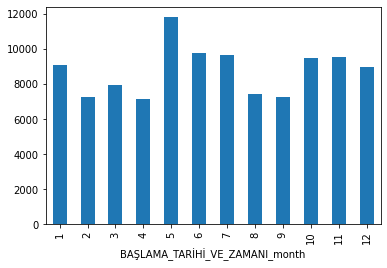

In [166]:
df.groupby('BAŞLAMA_TARİHİ_VE_ZAMANI_month')["cagri_count"].count().plot(kind="bar")

<AxesSubplot:xlabel='BAŞLAMA_TARİHİ_VE_ZAMANI_month'>

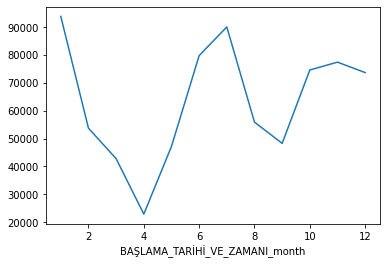

In [167]:
df.groupby('BAŞLAMA_TARİHİ_VE_ZAMANI_month')["cagri_count"].sum().plot(kind="line")

#### Calling counts are much more in Summer, Fall, Winter

<AxesSubplot:xlabel='BAŞLAMA_TARİHİ_VE_ZAMANI_hour'>

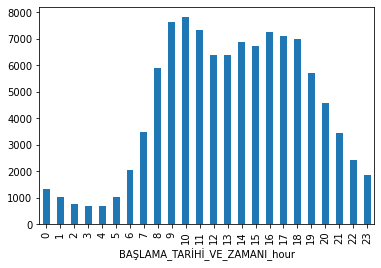

In [168]:
df.groupby('BAŞLAMA_TARİHİ_VE_ZAMANI_hour')["cagri_count"].count().plot(kind="bar")

#### Between the 9 a.m. and 18(6 p.m.) calling counts are majority. It can be happened from the working hours.

<AxesSubplot:xlabel='SONA_ERME_TARİHİ_VE_ZAMANI_hour'>

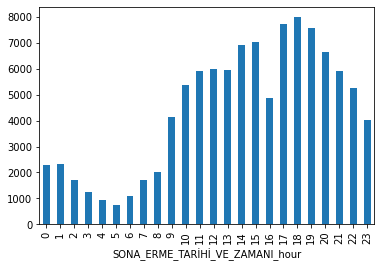

In [169]:
df.groupby('SONA_ERME_TARİHİ_VE_ZAMANI_hour')["cagri_count"].count().plot(kind="bar")

#### If interruption is still going untill the 18-20(6 p.m - 8 p.m), calling counts are increasing.

### KENTSEL_OG

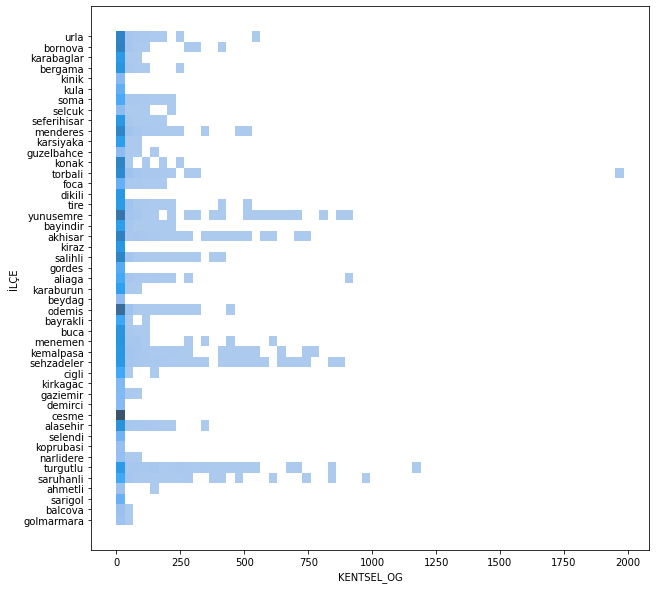

In [170]:
sns.histplot(data=df, x="KENTSEL_OG", y="İLÇE", bins=60)
fig = plt.gcf()
fig.set_size_inches(10,10)

### KENTSEL_AG

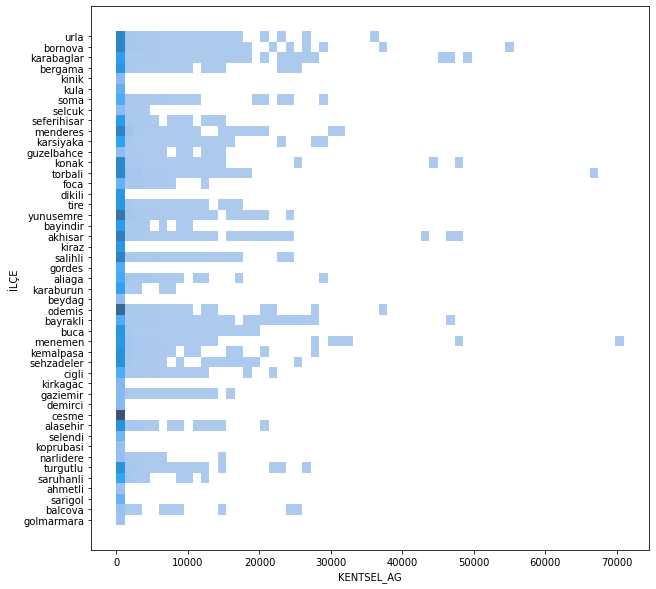

In [171]:
sns.histplot(data=df, x="KENTSEL_AG", y="İLÇE", bins=60)
fig = plt.gcf()
fig.set_size_inches(10,10)

#### KENTSEL_AG-KENTSEL_OG-KENTALTI_OG-KENTALTI_AG-KIRSAL_OG-KIRSAL_AG-TOPLAM_KENTSEL_OG-TOPLAM_KENTSEL_AG-TOPLAM_KENTALTI_OG-TOPLAM_KENTALTI_AG-TOPLAM_KIRSAL_OG-TOPLAM_KIRSAL_AG
#### These features show total interruption time and interruption count according to the neighborhood of district.

### ilce_nufus

In [172]:
df["ilce_nufus"]= df["ilce_nufus"].astype(float)

<AxesSubplot:xlabel='ilce_nufus', ylabel='cagri_count'>

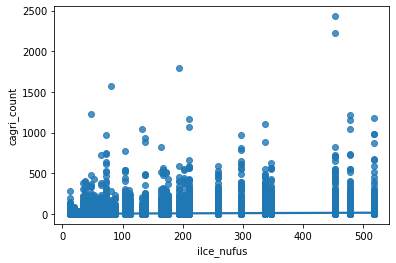

In [173]:
sns.regplot(data=df, x="ilce_nufus", y="cagri_count")

#### It seems there is no correlation between the ilce_nufus(distcrit population) and cagri_count. Let's examine it in the feature importance.

### holidays

<AxesSubplot:xlabel='holidays'>

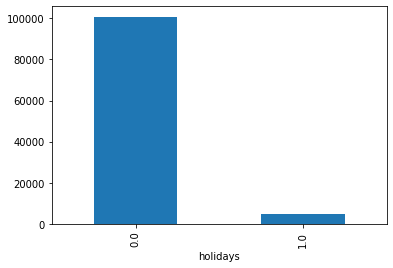

In [174]:
df.groupby("holidays")["cagri_count"].count().plot(kind="bar")

#### For our data, 4679 days coincide the holidays. We will see how importance it.

# REDUNDANT FEATURES

- **KESİNTİ_NO:** It can not be categorized, It just showing the IDnumbers of the interruption.
- **ŞEBEKE_UNSURU_KODU:** So confusing object and It can't be categorized too.
- **OutageID** and **KOD_NO**: Just ID numbers of outage, They are redundant.
- **BİLDİRİME_GÖRE:** Like I said, There are only one type of the feature. So, it's redundant because we haven't any other information to compare the cagri_count.
- **KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA:** Also, I have mentioned this feature too in EDA. There are 65 type of reason of interruption. We can't categorize it and we have OG-AG informations from the "Kaynağa_Göre" and we have another informations from "Süreye_göre, Sebebe_Göre".
- **İLÇE:** There are 47 types of the "İLÇE". So, we can't categorize it also. In addition, we have "ilce_nufus"(population) data, so we already have information's of "İLÇE".
- **BAŞLAMA_TARİHİ_VE_ZAMANI** and **SONA_ERME_TARİHİ_VE_ZAMANI:** We already have "KESİNTİ_SÜRESİ"(interruption time) and we transformed datetime features into month, year and hour.
- **DATE:** I used this feature to merge the datasets. Now, we don't need to this feature. Let's drop it too.
- **KADEME:** It is using for the splitting train and test dataset, but we have already type.

In [175]:
df.drop(["KESİNTİ_NO","ŞEBEKE_UNSURU_KODU","OutageID","KOD_NO","BİLDİRİME_GÖRE",
         "SONA_ERME_TARİHİ_VE_ZAMANI",
        "BAŞLAMA_TARİHİ_VE_ZAMANI","DATE","KADEME"], axis=1,inplace=True)

### Let's look at the our new dataframe

In [176]:
df.head()

,İL,İLÇE,ŞEBEKE_UNSURU,KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA,KAYNAĞA_GÖRE,SÜREYE_GÖRE,SEBEBE_GÖRE,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,cagri_count,type,ilce_nufus,holidays,BAŞLAMA_TARİHİ_VE_ZAMANI_year,BAŞLAMA_TARİHİ_VE_ZAMANI_month,BAŞLAMA_TARİHİ_VE_ZAMANI_hour,SONA_ERME_TARİHİ_VE_ZAMANI_year,SONA_ERME_TARİHİ_VE_ZAMANI_month,SONA_ERME_TARİHİ_VE_ZAMANI_hour
0,izmir,urla,OG Fideri,OG Sigorta Atması,Dağıtım-OG,Uzun,Şebeke işletmecisi,3.073056,1,146,0,0,0,0,3.073056,448.666111,0.0,0.0,0.0,0.0,0.0,train,72.741,0.0,2022,11,7,2022,11,10
1,izmir,bornova,OG Fideri,OG Fider Açması,Dağıtım-OG,Uzun,Şebeke işletmecisi,5.084444,3,1613,0,0,0,0,15.253333,8201.208888,0.0,0.0,0.0,0.0,153.0,train,452.867,0.0,2022,1,20,2022,1,1
2,izmir,bornova,OG Fideri,OG Fider Açması,Dağıtım-OG,Uzun,Şebeke işletmecisi,1.729167,3,1613,0,0,0,0,5.187500,2789.145832,0.0,0.0,0.0,0.0,8.0,train,452.867,0.0,2022,1,3,2022,1,5
3,izmir,karabaglar,TM Fideri,OG Yeraltı Kablo Arızası,Dağıtım-OG,Uzun,Şebeke işletmecisi,0.778889,6,1556,0,0,0,0,4.673333,1211.951110,0.0,0.0,0.0,0.0,0.0,train,478.788,0.0,2022,3,16,2022,3,17
4,izmir,bergama,OG Fideri,OG Sigorta Atması,Dağıtım-OG,Uzun,Şebeke işletmecisi,1.558333,1,101,0,0,0,0,1.558333,157.391667,0.0,0.0,0.0,0.0,0.0,train,104.980,0.0,2022,3,21,2022,3,22


# FEATURE TRANSFORMATION

#### **We have categorical data, we need to convert them into numerical. Because machine learning algorithms can't work with the categorical data.**

### LABEL ENCODING

#### İL, SÜREYE_GÖRE, SONA_ERME_TARİHİ_VE_ZAMANI_year and BAŞLAMA_TARİHİ_VE_ZAMANI_year

In [177]:
lbe = LabelEncoder()
df["İL"] = lbe.fit_transform(df['İL'])
df["SÜREYE_GÖRE"] = lbe.fit_transform(df['SÜREYE_GÖRE'])
df['BAŞLAMA_TARİHİ_VE_ZAMANI_year'] = lbe.fit_transform(df['BAŞLAMA_TARİHİ_VE_ZAMANI_year'])
df['SONA_ERME_TARİHİ_VE_ZAMANI_year'] = lbe.fit_transform(df['SONA_ERME_TARİHİ_VE_ZAMANI_year'])

### ONE-HOT ENCODING

#### ŞEBEKE_UNSURU, KAYNAĞA_GÖRE, SEBEBE_GÖRE, BAŞLAMA_TARİHİ_VE_ZAMANI_month,
#### BAŞLAMA_TARİHİ_VE_ZAMANI_hour,SONA_ERME_TARİHİ_VE_ZAMANI_hour,SONA_ERME_TARİHİ_VE_ZAMANI_month

In [178]:
for i in ["ŞEBEKE_UNSURU","KAYNAĞA_GÖRE","SEBEBE_GÖRE","BAŞLAMA_TARİHİ_VE_ZAMANI_month",
"BAŞLAMA_TARİHİ_VE_ZAMANI_hour","SONA_ERME_TARİHİ_VE_ZAMANI_hour","SONA_ERME_TARİHİ_VE_ZAMANI_month",
          "KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA","İLÇE"]:
    df = pd.get_dummies(df, columns = [f"{i}"], prefix = [f"{i}"], drop_first = True)

#### Let's look at the dataframe after the transformations

In [179]:
df.shape

(122141, 211)

#### We need to clean spaces in columns names

In [180]:
df.columns = df.columns.str.replace(' ', '_')

### SPLIT OPERATIONS

In [181]:
df_train = df.query("type=='train'")
df_test = df.query("type=='test'")

df_train.drop(["type"],axis=1,inplace=True)
df_test.drop(["type","cagri_count"],axis=1,inplace=True)

In [182]:
y_train = df_train["cagri_count"]
X_train = df_train.drop(labels = ["cagri_count"],axis = 1)
X_test = df_test

### STANDARDIZATION

#### **Standardızatıon provide faster process and well results when ML algorithm use distance to compute.**

In [183]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X_train)

In [184]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X_test)

In [185]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# MODEL

#### **I have tried more than 10 algorithms, then I decided to continue with the LGBMRegressor.**

In [186]:
random_state = 42
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=random_state)
def RMSE(estimator, X_train, Y_train, cv=rkf,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [187]:
lgbm_model = lgbm.LGBMRegressor(random_state=random_state).fit(X_train,y_train)
print("With all features(210) rmse is:", RMSE(lgbm_model, X_train, y_train))

With all features(210) rmse is: 24.888904283816075


# FEATURE SELECTION

In [188]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [194]:
for i in range(160,191):
    fs = SelectKBest(score_func=chi2, k=i)
    z = fs.fit_transform(X_train,y_train)
    filters = fs.get_support()
    features = np.array(X_train.columns)
    column_list = []
    for j in features[filters]: 
        column_list.append(j.replace(" ", ","))
    for a in range(1):
        X_train_f = X_train[column_list]
        X_test_f = X_test[column_list]
        lgbm_model = lgbm.LGBMRegressor(random_state=random_state).fit(X_train_f,y_train)
        print(f"After selecting best {i} features rmse is:", RMSE(lgbm_model, X_train_f, y_train))

After selecting best 160 features rmse is: 24.901581489311194
After selecting best 161 features rmse is: 24.89400256018566
After selecting best 162 features rmse is: 24.89400256018566
After selecting best 163 features rmse is: 24.87984985551197
After selecting best 164 features rmse is: 24.87170789144653
After selecting best 165 features rmse is: 24.87170789144653
After selecting best 166 features rmse is: 24.896969371183545
After selecting best 167 features rmse is: 24.896969371183545
After selecting best 168 features rmse is: 24.896969371183545
After selecting best 169 features rmse is: 24.89581555115788
After selecting best 170 features rmse is: 24.89581555115788
After selecting best 171 features rmse is: 24.895616638325567
After selecting best 172 features rmse is: 24.894942249665686
After selecting best 173 features rmse is: 24.895039222409455
After selecting best 174 features rmse is: 24.880967916679452
After selecting best 175 features rmse is: 24.880967916679452
After selecting

#### **A little better than the base model result, we can continue with the 189 features**

In [211]:

fs = SelectKBest(score_func=chi2, k=189)
z = fs.fit_transform(X_train,y_train)
filters = fs.get_support()
features = np.array(X_train.columns)
column_list = []

for j in features[filters]: 
    column_list.append(j.replace(" ", ","))

X_train_f = X_train[column_list]
X_test_f = X_test[column_list]
lgbm_model = lgbm.LGBMRegressor(random_state=random_state).fit(X_train_f,y_train)
print(f"After selecting best {i} features rmse is:", RMSE(lgbm_model, X_train_f, y_train))

After selecting best 190 features rmse is: 24.845745794471824


# TUNING WITH OPTUNA

#### I'll try tuning with lgbm model

In [210]:
pip install verstack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 36.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 35.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 36.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.2/227.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.6/86.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━

In [212]:
from verstack import LGBMTuner

2022-09-15 11:15:32.371683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-09-15 11:15:32.371751: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 500 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 20.65400837435756
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 26.210256514799635
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 22.9029939008676
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 27.523372895657328
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 25.000230906510634
 .................................................

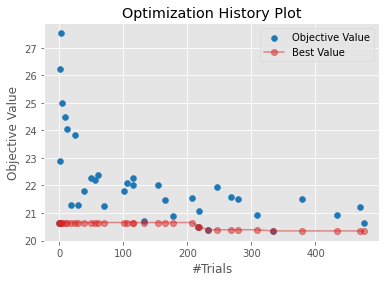

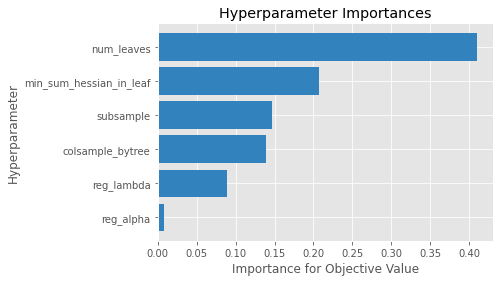

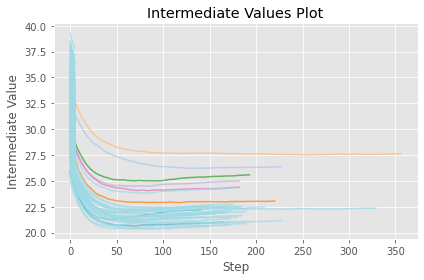

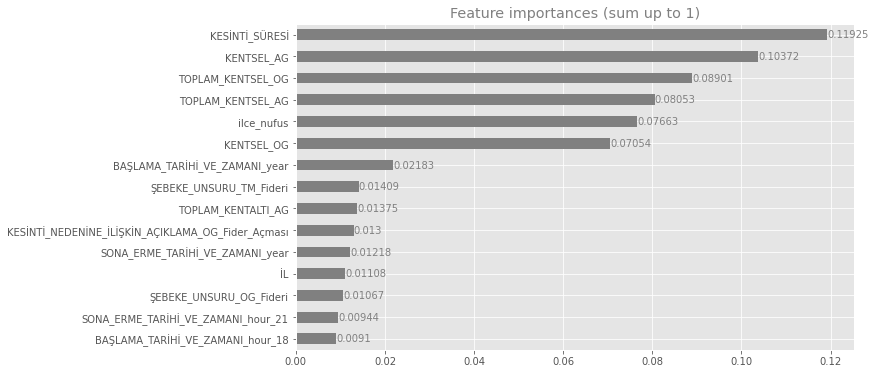


     . Optuna hyperparameters optimization finished
     .. Best trial number:333    |     rmse:            20.34899884514065
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  126   |     rmse:            24.70616537882737

Time elapsed for fit execution: 8 min 15.552 sec


In [213]:
tuner = LGBMTuner(metric = 'rmse',trials = 500) 
tuner.fit(X_train_f, y_train)

### SUBMISSION

In [225]:
lgbm_model = lgbm.LGBMRegressor(learning_rate= 0.04,
num_leaves = 117,
colsample_bytree = 0.5336448267666282,
subsample = 0.5027914171463564,
num_threads = 2,
min_sum_hessian = 8.34994309372606,
reg_alpha = 0.02500044242334467,
reg_lambda = 6.6434172642915154e-06,
n_estimators = 126, random_state=random_state).fit(X_train,y_train)
RMSE(lgbm_model, X_train, y_train)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_sum_hessian=8.34994309372606, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.34994309372606
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2


24.942911783235168

## We couldn't get a better value after the optimization so I'll use the base model with feature selected

In [226]:
lgbm_model = lgbm.LGBMRegressor(random_state=random_state).fit(X_train_f,y_train)
pred_y = lgbm_model.predict(X_test_f)

In [227]:
pred_y = pd.DataFrame(y_pred, columns=["cagri_count"])

In [228]:
pred_y.shape

(16751, 1)

In [229]:
submission = pd.read_csv("../input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/submission.csv")

In [230]:
submission.shape

(16751, 2)

In [231]:
submission_last = pd.concat([submission[["KESİNTİ_NO"]],pred_y],axis=1)

In [232]:
submission_last.to_csv('gdzsubmission17.csv',index=False)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_sum_hessian=8.34994309372606, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.34994309372606
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_sum_hessian=8.34994309372606, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.34994309372606
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_sum_hessian=8.34994309372606, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.34994309372606
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_sum_hessian=8.34994309372606, min_child_weight=0.001 will be ignored. Current val